# Problem 1
Consider the Lorenz' 96 system that we solved in the class with $8 X$ variables, $64 Y$ variables, and $512 Z$ variables.

$$
\begin{aligned}
\frac{d X_k}{d t} & =X_{k-1}\left(X_{k+1}-X_{k-2}\right)-X_k+F-\frac{h c}{b} \Sigma_j Y_{j, k} \\
\frac{d Y_{j, k}}{d t} & =-c b Y_{j+1, k}\left(Y_{j+2, k}-Y_{j-1, k}\right)-c Y_{j, k}+\frac{h c}{b} X_k-\frac{h e}{d} \Sigma_i Z_{i, j, k} \\
\frac{d Z_{i, j, k}}{d t} & =e d Z_{i-1, j, k}\left(Z_{i+1, j, k}-Z_{i-2, j, k}\right)-g e Z_{i, j, k}+\frac{h e}{d} Y_{j, k}
\end{aligned}
$$

where $i, j, k=1,2, \ldots 8$, i.e., there are 8 equations for $X$, and 64 and 512 equations for $Y$ and $Z$, respectively. Ignore the $Z$ variables completely. Keep all the paramters the same as was done in class and write code for the following problems:

## Part A:
(a) Follow the procedure in class, and train a model that can predict Y (t)
as a function of X(t). Show how accurate the value of Y is on an unknown test
set as well as the value of Σj Yj,k Call this model, M1

In [668]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from scipy.integrate import solve_ivp


First we solve the lorenz system for x and y analytically to generate train/test datasets

In [669]:
# Define simulation parameters
K = 8       # X (K=8)
J = 8       # Y (K*J=64)
I = 8       # Z (K*J*I=512)

F = 20      # Forcing parameter (high chaos)
h = 0.5     # Coupling parameter (medium coupling)
c = 8    # Time Scale parameter (small scale Y evolves faster than X)
# b = 1.0     # Parameter b (assumed to be 1 here)

dt = 0.005  # Time step for integration
max_t = 750 # Total simulation time
num_steps = int(max_t / dt)  # Number of integration steps


In [670]:
def step(x_vec, y_mat, z_mat):
    b = 10
    e = 10
    d = 10
    minus = [-1, 0, 1, 2, 3, 4, 5, 6]
    minus2 = [-2, -1, 0, 1, 2, 3, 4, 5]
    plus = [1, 2, 3, 4, 5, 6, 7, 0]
    plus2 = [2, 3, 4, 5, 6, 7, 0, 1]
    x_minus = x_vec[minus]
    x_minus2 = x_vec[minus2]
    x_plus = x_vec[plus]

    y_minus = y_mat[minus, :]
    y_plus = y_mat[plus, :]
    y_plus2 = y_mat[plus2, :]

    z_minus = z_mat[minus, :, :]
    z_minus2 = z_mat[minus2, :, :]
    z_plus = z_mat[plus, :, :]

    y_k = np.sum(y_mat, 0)

    z_kj = np.sum(z_mat, 0)

    dx = x_minus * (x_plus - x_minus2) - x_vec + F - (h * c / b) * y_k

    dy = -c * b * y_plus * (y_plus2 - y_minus) - c * y_mat + (h * c / b) * x_vec - (h * e / d) * z_kj

    dz = e * d * z_minus * (z_plus - z_minus2) - e * z_mat + (h * e / d) * y_mat
    return dx, dy, dz

Simulation complete.
Shape of X: (150000, 8)
Shape of Y: (150000, 64)


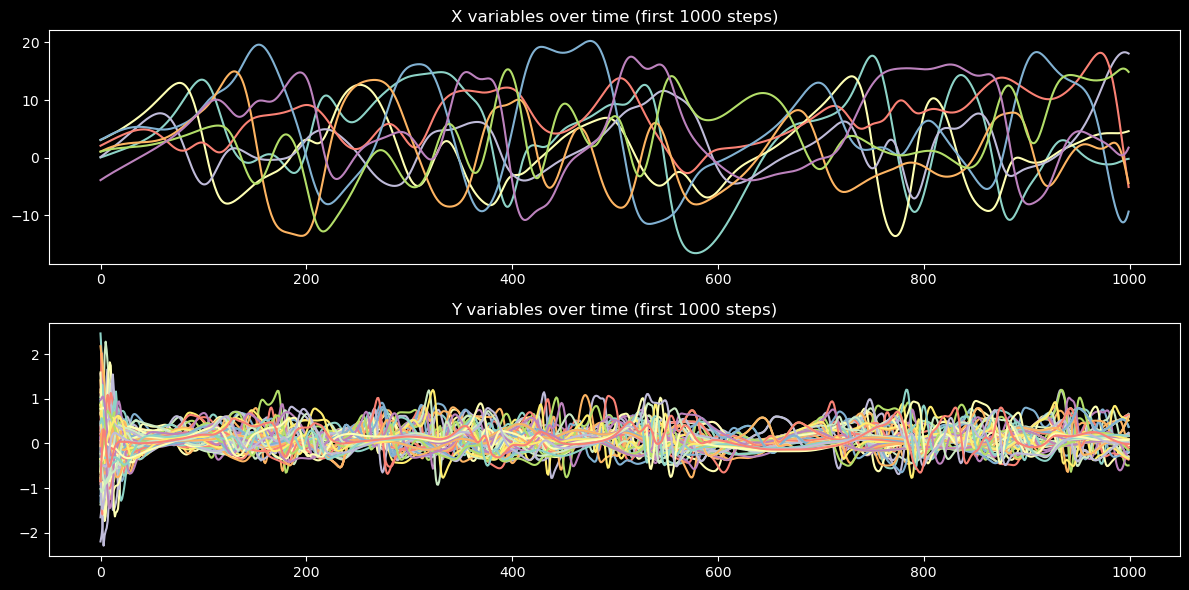

In [671]:
# Set random seed for reproducibility
np.random.seed(65)

# Initial conditions
X = np.random.randint(-5, 5, K).astype(float)
Y = np.random.randn(J, K)
# Z is unused but defined as a JXKXI tensor
Z = 0.05*np.random.randn(J,K,I)

X_sol = np.zeros((num_steps, K))
Y_sol = np.zeros((num_steps, int(K*J)))

for i in range(int(max_t/dt)):

    [dx1, dy1, dz1] = step(X,Y,Z)

    Rx2=X+.5*dt*dx1
    Ry2=Y+.5*dt*dy1
    Rz2=Z+.5*dt*dz1

    [dx2, dy2, dz2] = step(Rx2,Ry2,Rz2)

    Rx3=X+.5*dt*dx2
    Ry3=Y+.5*dt*dy2
    Rz3=Z+.5*dt*dz2

    [dx3, dy3, dz3] = step(Rx3,Ry3,Rz3)

    Rx4=X+dt*dx3
    Ry4=Y+dt*dy3
    Rz4=Z+dt*dz3

    [dx4, dy4, dz4] = step(Rx4,Ry4,Rz4)
    X=X+dt/6*(dx1 + 2*dx2 + 2*dx3 + dx4)
    Y=Y+dt/6*(dy1 + 2*dy2 + 2*dy3 + dy4)
    Z=Z+dt/6*(dz1 + 2*dz2 + 2*dz3 + dz4)

    X_sol[i,:]=X

    Y_sol[i,:]=Y.reshape((int(J*K),),order='F')


print("Simulation complete.")
print("Shape of X:", X_sol.shape)
print("Shape of Y:", Y_sol.shape)

# Optional: Plot a small segment of the simulation for visualization
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(X_sol[:1000])
plt.title("X variables over time (first 1000 steps)")
plt.subplot(2, 1, 2)
plt.plot(Y_sol[:1000])
plt.title("Y variables over time (first 1000 steps)")
plt.tight_layout()
plt.show()

In [672]:
print('c='+str(c)+' h='+str(h)+' F='+str(F))
# Normalize the data (zero mean, unit variance) for X and Y separately
X_mean = np.mean(X_sol)
X_std = np.std(X_sol)
x_store_norm = (X_sol - X_mean) / X_std

print(f"x mean: {X_mean}")
print(f"x std: {X_std}")

Y_mean = np.mean(Y_sol)
Y_std = np.std(Y_sol)
y_store_norm = (Y_sol - Y_mean) / Y_std

print(f"y mean: {Y_mean}")
print(f"y std: {Y_std}")

data_norm=np.vstack((x_store_norm.transpose(),y_store_norm.transpose()))
print(data_norm.shape)

# Split the normalized data into training (80%) and testing (20%) sets
num_train = int(0.8 * num_steps)
X_train = x_store_norm[:num_train]
Y_train = y_store_norm[:num_train]
X_test = x_store_norm[num_train:]
Y_test = y_store_norm[num_train:]

# Convert the numpy arrays to PyTorch tensors for training
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)



c=8 h=0.5 F=20
x mean: 3.4150660808219397
x std: 7.217622889095587
y mean: 0.10987046874973459
y std: 0.23909636354332936
(72, 150000)


shape of X (150000, 8)
shape of Y (150000, 64)


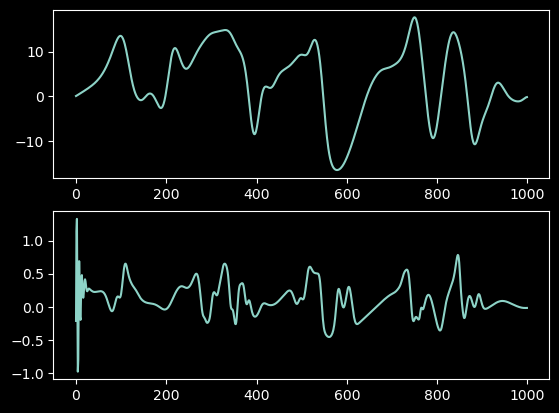

In [673]:
print('shape of X', np.shape(X_sol))
print('shape of Y', np.shape(Y_sol))


plt.subplot(2,1,1)
plt.plot(X_sol[0:1000,0])

plt.subplot(2,1,2)
plt.plot(Y_sol[0:1000,0])



Define Our Network

In [674]:
# Define the neural network model that predicts Y from X
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input layer: from 8 (X variables) to 128 parameters
        self.fc1 = nn.Linear(8, 128)
        # Hidden layers with 256 params each
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        # Output layer: from 256 params to 64 outputs (Y variables)
        self.fc5 = nn.Linear(256, 64)
        
    def forward(self, x):
        # non linear hidden layers
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        # linear output layer 
        x = self.fc5(x)
        return x

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
M1 = Net().to(device)
print("Neural network model (M1):")
print(M1)

Neural network model (M1):
Net(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=64, bias=True)
)


Train Network to our Lorenz System

In [675]:

# Define loss function and optimizer
criterion = nn.MSELoss() # Mean Squared Error loss
optimizer = optim.Adam(M1.parameters(), lr=1e-3)  # Adam optimizer

# Set training hyperparameters
num_epochs = 100 # Number of epochs for training
batch_size = 100 # Batch size for training
num_batches = 10000

LOSS = []

for epoch in range(num_epochs):
    for iter in range (0, num_batches, batch_size):
        batch_X = X_train_tensor[iter:iter+batch_size,:]
        batch_Y = Y_train_tensor[iter:iter+batch_size,:]
        optimizer.zero_grad() # specify that all gradients should be set to zero, otherwise they are accumulated across every iteration
        outputs = M1(batch_X.to(device))
        loss = criterion(outputs, batch_Y.to(device)) # commpute loss, sutract output from target
        loss.backward() # calculate gradients for all parameters
        optimizer.step() # update parameters of the model
    LOSS.append(loss.detach().cpu().numpy())
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 0.8617
Epoch [20/100], Loss: 0.7673
Epoch [30/100], Loss: 0.7053
Epoch [40/100], Loss: 0.6429
Epoch [50/100], Loss: 0.5874
Epoch [60/100], Loss: 0.5248
Epoch [70/100], Loss: 0.4276
Epoch [80/100], Loss: 0.3459
Epoch [90/100], Loss: 0.3006
Epoch [100/100], Loss: 0.2521



Test Loss (MSE on Y): 1.057468056678772
Test Loss (MSE on summed Y): 9.088529586791992


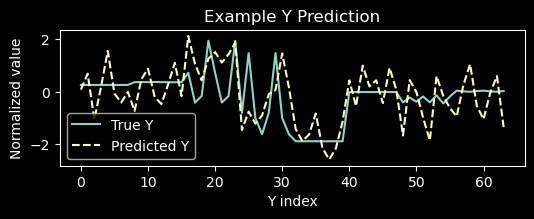

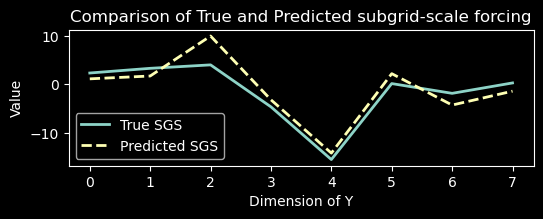

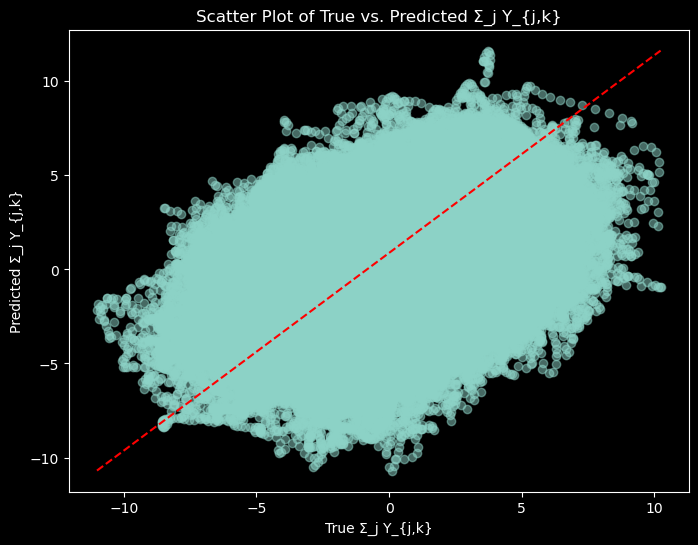

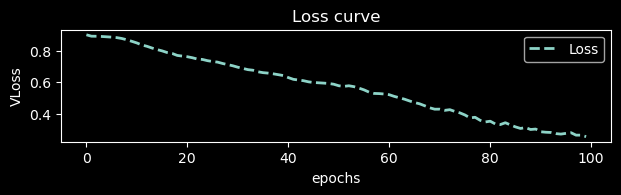

In [676]:

M1.eval()  # Set model to evaluation mode (disables dropout, batch norm, etc.)
with torch.no_grad():
    # Predict Y values on the test set
    Y_pred_test = M1(X_test_tensor.float().to(device)).detach().cpu()
    
    # Compute the mean squared error on Y predictions
    test_loss = criterion(Y_pred_test, Y_test_tensor).item()
    print("\nTest Loss (MSE on Y):", test_loss)
    
    # Compute the sum of Y values for each test sample (summing over the 64 outputs)
    Y_pred_test_reshaped = Y_pred_test.view(-1, J, K)  # Reshape to (samples, J, K)
    Y_test_tensor_reshaped = Y_test_tensor.view(-1, J, K)  # Same for true values
    Y_pred_sum = Y_pred_test_reshaped.sum(dim=1)
    Y_test_sum = Y_test_tensor_reshaped.sum(dim=1)
    
    # Compute the MSE loss for the summed Y values
    sum_loss = criterion(Y_pred_sum, Y_test_sum).item()
    print("Test Loss (MSE on summed Y):", sum_loss)


# Plot an example of predicted Y vs true Y for one test sample
plt.figure(figsize=(6, 6))
plt.subplot(3, 1, 1)
plt.plot(Y_test_tensor[0].numpy(), label="True Y")
plt.plot(Y_pred_test[0].numpy(), label="Predicted Y", linestyle='dashed')
plt.title("Example Y Prediction")
plt.xlabel("Y index")
plt.ylabel("Normalized value")
plt.legend()

compute_SGS = lambda Y: np.sum(Y.reshape(8, 8), axis=1)

predicted_SGS = compute_SGS(Y_pred_test[1].numpy())
true_SGS = compute_SGS(Y_test_tensor[1].numpy())

plt.figure(figsize=(6, 6))
plt.subplot(3,1,2)
plt.plot(true_SGS, label='True SGS', linewidth=2)
plt.plot(predicted_SGS, '--', label='Predicted SGS', linewidth=2)
plt.title('Comparison of True and Predicted subgrid-scale forcing')
plt.xlabel('Dimension of Y')
plt.ylabel('Value')
plt.legend()
plt.show()


x_range = (Y_test_sum.cpu().numpy().flatten().min(),Y_test_sum.cpu().numpy().flatten().max())
y_range = (Y_pred_sum.cpu().numpy().flatten().min(), Y_pred_sum.cpu().numpy().flatten().max())
# Plot the true sum of Y values vs. the predicted sum for all test samples
plt.figure(figsize=(8, 6))
plt.scatter(Y_test_sum.cpu().numpy().flatten(), Y_pred_sum.cpu().numpy().flatten(), alpha=0.5)
plt.xlabel("True Σ_j Y_{j,k}")
plt.ylabel("Predicted Σ_j Y_{j,k}")
plt.title("Scatter Plot of True vs. Predicted Σ_j Y_{j,k}")
plt.plot(x_range, y_range, 'r--')  # Identity line
plt.show()

plt.subplot(3,1,3)
plt.plot(LOSS, '--', label='Loss', linewidth=2)
plt.title('Loss curve')
plt.xlabel('epochs')
plt.ylabel('VLoss')
plt.legend()

plt.tight_layout()
plt.show()

## Part B
Now, simulate the system again with F = 24. Using M1 as the model,
but new X values as input and show how well the new values of Y as well as
Σj Yj,k is predicted. Now, fine-tune the model with the new data to make it
work on this new system

In [677]:
# Re-Define simulation parameters with F=24 
K = 8       # X (K=8)
J = 8       # Y (K*J=64)
I = 8       # Z (K*J*I=512)

F = 24      # Update Forcing Parameter
h = 0.5     # Coupling parameter (medium coupling)
c = 8    # Time Scale parameter (small scale Y evolves faster than X)
# b = 1.0     # Parameter b (assumed to be 1 here)

dt = 0.005  # Time step for integration
max_t = 750 # Total simulation time
num_steps = int(max_t / dt)  # Number of integration steps


Simulation complete.
Shape of X: (150000, 8)
Shape of Y: (150000, 64)


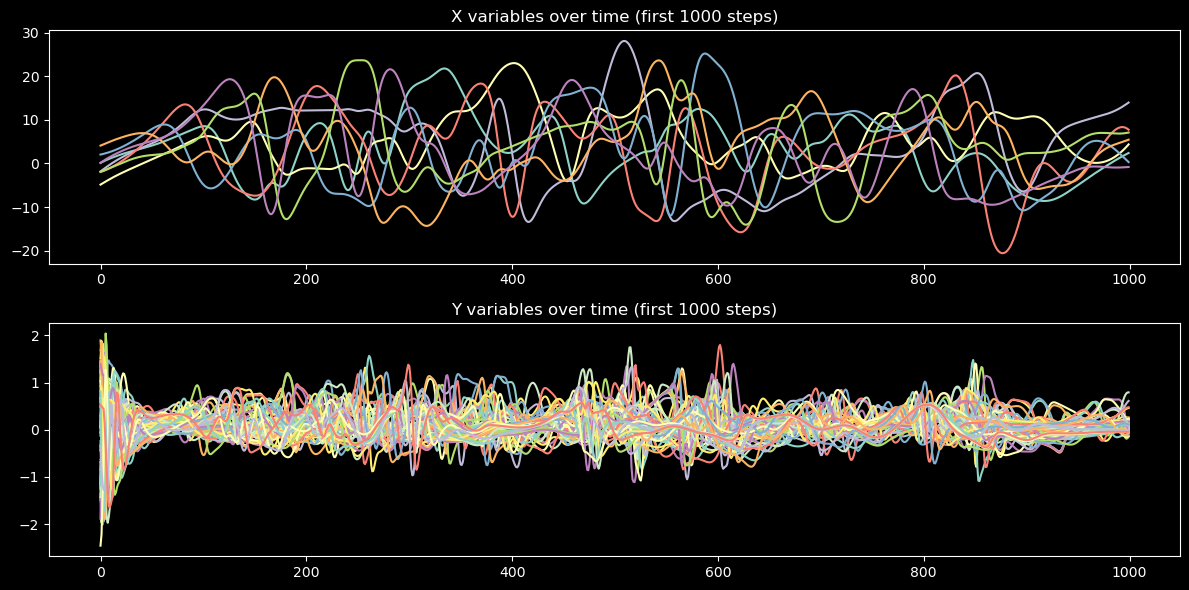

In [678]:
np.random.seed(0) # change seed for a new set of results

# Initial conditions
X = np.random.randint(-5, 5, K).astype(float)
Y = np.random.randn(J, K)
# Z is unused but defined as a JXKXI tensor
Z = 0.05*np.random.randn(J,K,I)

X_sol = np.zeros((num_steps, K))
Y_sol = np.zeros((num_steps, int(K*J)))

for i in range(num_steps):

    [dx1, dy1, dz1] = step(X,Y,Z)

    Rx2=X+.5*dt*dx1
    Ry2=Y+.5*dt*dy1
    Rz2=Z+.5*dt*dz1

    [dx2, dy2, dz2] = step(Rx2,Ry2,Rz2)

    Rx3=X+.5*dt*dx2
    Ry3=Y+.5*dt*dy2
    Rz3=Z+.5*dt*dz2

    [dx3, dy3, dz3] = step(Rx3,Ry3,Rz3)

    Rx4=X+dt*dx3
    Ry4=Y+dt*dy3
    Rz4=Z+dt*dz3

    [dx4, dy4, dz4] = step(Rx4,Ry4,Rz4)
    X=X+dt/6*(dx1 + 2*dx2 + 2*dx3 + dx4)
    Y=Y+dt/6*(dy1 + 2*dy2 + 2*dy3 + dy4)
    Z=Z+dt/6*(dz1 + 2*dz2 + 2*dz3 + dz4)

    X_sol[i,:]=X

    Y_sol[i,:]=Y.reshape((int(J*K),),order='F')



print("Simulation complete.")
print("Shape of X:", X_sol.shape)
print("Shape of Y:", Y_sol.shape)

# Optional: Plot a small segment of the simulation for visualization
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(X_sol[:1000])
plt.title("X variables over time (first 1000 steps)")
plt.subplot(2, 1, 2)
plt.plot(Y_sol[:1000])
plt.title("Y variables over time (first 1000 steps)")
plt.tight_layout()
plt.show()

In [679]:
print('c='+str(c)+' h='+str(h)+' F='+str(F))
# Normalize the data (zero mean, unit variance) for X and Y separately
X_mean = np.mean(X_sol)
X_std = np.std(X_sol)
x_store_norm = (X_sol - X_mean) / X_std

print(f"x mean: {X_mean}")
print(f"x std: {X_std}")

Y_mean = np.mean(Y_sol)
Y_std = np.std(Y_sol)
y_store_norm = (Y_sol - Y_mean) / Y_std

print(f"y mean: {Y_mean}")
print(f"y std: {Y_std}")

data_norm=np.vstack((x_store_norm.transpose(),y_store_norm.transpose()))
print(data_norm.shape)

num_train = int(0.8 * num_steps)
X_train = x_store_norm[:num_train]
Y_train = y_store_norm[:num_train]
X_test = x_store_norm[num_train:]
Y_test = y_store_norm[num_train:]

# Convert the numpy arrays to PyTorch tensors for training
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

X_tensor = X_test_tensor
Y_tensor = Y_test_tensor


c=8 h=0.5 F=24
x mean: 3.6348113333385688
x std: 8.297909081345976
y mean: 0.1065520036672032
y std: 0.26003312065571366
(72, 150000)


shape of X (150000, 8)
shape of Y (150000, 64)


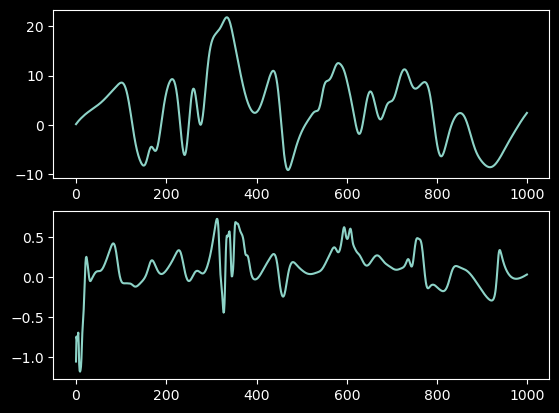

In [680]:
print('shape of X', np.shape(X_sol))
print('shape of Y', np.shape(Y_sol))


plt.subplot(2,1,1)
plt.plot(X_sol[0:1000,0])

plt.subplot(2,1,2)
plt.plot(Y_sol[0:1000,0])



Neural network model (M1):
Net(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=64, bias=True)
)

Test Loss (MSE on Y): 1.1049734354019165
Test Loss (MSE on summed Y): 9.394478797912598
Y_pred shape:
torch.Size([64])


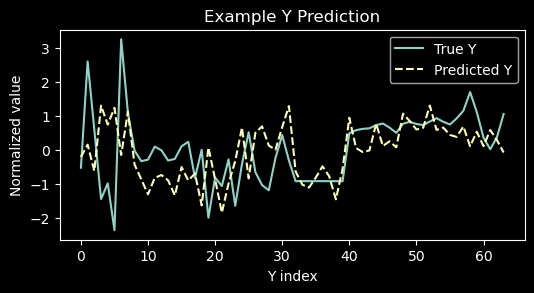

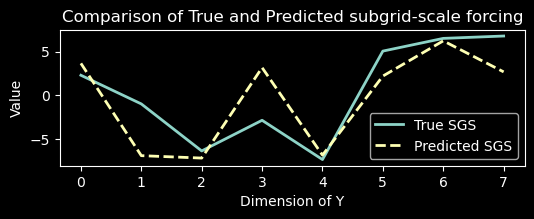

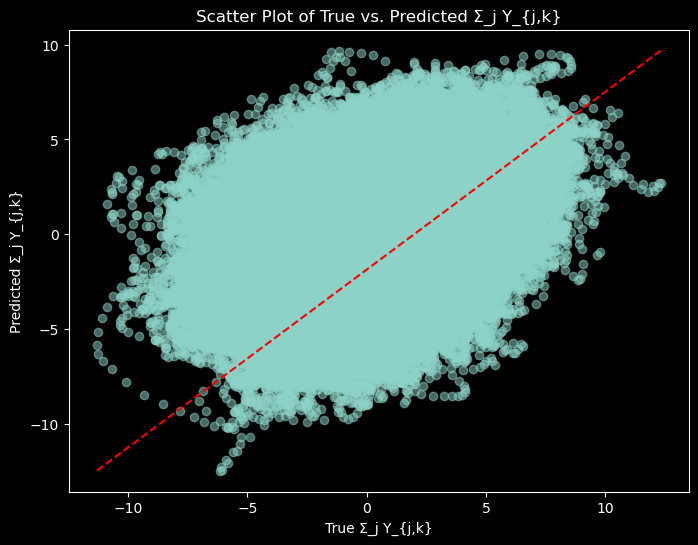

<Figure size 640x480 with 0 Axes>

In [681]:
print("Neural network model (M1):")
print(M1)

# Predict Y values on the test set
Y_pred = M1(X_tensor.float().to(device)).detach().cpu()
# y pred is the predicted Y values with shape (num_samples, 64), 8 Y values for every X value

# Compute the mean squared error on Y predictions
test_loss = criterion(Y_pred, Y_tensor).item()
print("\nTest Loss (MSE on Y):", test_loss)


# Compute the sum of Y values for each test sample (summing over the 64 outputs)
Y_pred_reshaped = Y_pred.view(-1, J, K)  # Reshape to (samples, J, K)
Y_tensor_reshaped = Y_tensor.view(-1, J, K)  # Same for true values
# reshaped so that we can sum over the J dimension
Y_pred_sum = Y_pred_reshaped.sum(dim=1)
Y_sum = Y_tensor_reshaped.sum(dim=1)
# Σ_j Y_j,k
# y_pred_sum is the sum is now a (num_samples, 8) tensor, 1 sum for every X value
# y sum is then the true sum of Y values for each X value

# Compute the MSE loss for the summed Y values
sum_loss = criterion(Y_pred_sum, Y_sum).item()
print("Test Loss (MSE on summed Y):", sum_loss)


# Plot an example of predicted Y vs true Y for one test sample
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(Y_tensor[0].numpy(), label="True Y")
plt.plot(Y_pred[0].numpy(), label="Predicted Y", linestyle='dashed')
plt.title("Example Y Prediction")
plt.xlabel("Y index")
plt.ylabel("Normalized value")
plt.legend()

compute_SGS = lambda Y: np.sum(Y.reshape(8, 8), axis=1)

print("Y_pred shape:")
print(Y_pred[1].shape)
predicted_SGS = compute_SGS(Y_pred[0].numpy())
true_SGS = compute_SGS(Y_tensor[0].numpy())

plt.figure(figsize=(6, 6))
plt.subplot(3,1,2)
plt.plot(true_SGS, label='True SGS', linewidth=2)
plt.plot(predicted_SGS, '--', label='Predicted SGS', linewidth=2)
plt.title('Comparison of True and Predicted subgrid-scale forcing')
plt.xlabel('Dimension of Y')
plt.ylabel('Value')
plt.legend()
plt.show()

Y_pred_sum = Y_pred_sum.cpu().numpy()
Y_sum = Y_sum.cpu().numpy()

x_range = (Y_sum.min(), Y_sum.max())
y_range = (Y_pred_sum.min(), Y_pred_sum.max())
#  Plot the true sum of Y values vs. the predicted sum for all test samples
plt.figure(figsize=(8, 6))
plt.scatter(Y_sum, Y_pred_sum, alpha=0.5)
plt.xlabel("True Σ_j Y_{j,k}")
plt.ylabel("Predicted Σ_j Y_{j,k}")
plt.title("Scatter Plot of True vs. Predicted Σ_j Y_{j,k}")
plt.plot(x_range, y_range, 'r--')  # Identity line
plt.show()


plt.tight_layout()
plt.show()

The model is clearly worse, but with the subgrid-scale forcing it still roughly estimates the Y values. Now we fine-tune the model to the new system to imrpove the predictions.

In [682]:
# we have our data sets X_sol and Y_sol with their
# normalized forms x_store_norm and y_store_norm

# Split the normalized data into training (80%) and testing (20%) sets
num_train = int(0.8 * num_steps)
X_train = x_store_norm[:num_train]
Y_train = y_store_norm[:num_train]
X_test = x_store_norm[num_train:]
Y_test = y_store_norm[num_train:]

# Convert the numpy arrays to PyTorch tensors for training
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)


In [683]:

# M1 = Net().to(device)
print("Neural network model (M1):")
print(M1)
M1.train() # set model to training mode

# Define loss function and optimizer
criterion = nn.MSELoss() # Mean Squared Error loss
optimizer = optim.Adam(M1.parameters(), lr=1e-3)  # Adam optimizer

# Set training hyperparameters
num_epochs = 100 # Number of epochs for training
batch_size = 100 # Batch size for training
num_batches = 10000

LOSS = []

for epoch in range(num_epochs):
    for iter in range (0, num_batches, batch_size):
        batch_X = X_train_tensor[iter:iter+batch_size,:]
        batch_Y = Y_train_tensor[iter:iter+batch_size,:]
        optimizer.zero_grad() # specify that all gradients should be set to zero, otherwise they are accumulated across every iteration
        outputs = M1(batch_X.to(device))
        loss = criterion(outputs, batch_Y.to(device)) # commpute loss, sutract output from target
        loss.backward() # calculate gradients for all parameters
        optimizer.step() # update parameters of the model
    LOSS.append(loss.detach().cpu().numpy())
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Neural network model (M1):
Net(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=64, bias=True)
)
Epoch [10/100], Loss: 0.6536
Epoch [20/100], Loss: 0.4716
Epoch [30/100], Loss: 0.4715
Epoch [40/100], Loss: 0.3412
Epoch [50/100], Loss: 0.3036
Epoch [60/100], Loss: 0.2936
Epoch [70/100], Loss: 0.2467
Epoch [80/100], Loss: 0.2480
Epoch [90/100], Loss: 0.2228
Epoch [100/100], Loss: 0.2004



Test Loss (MSE on Y): 1.1962376832962036
Test Loss (MSE on summed Y): 9.53065013885498


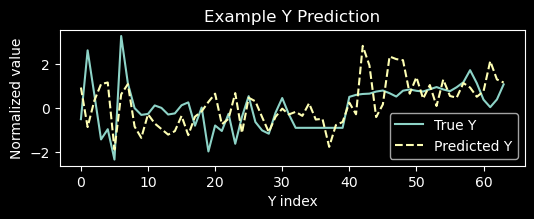

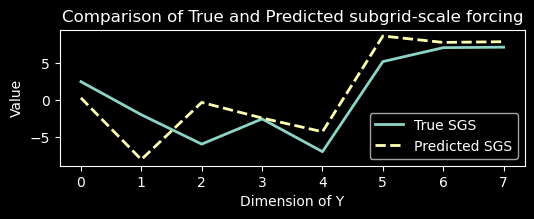

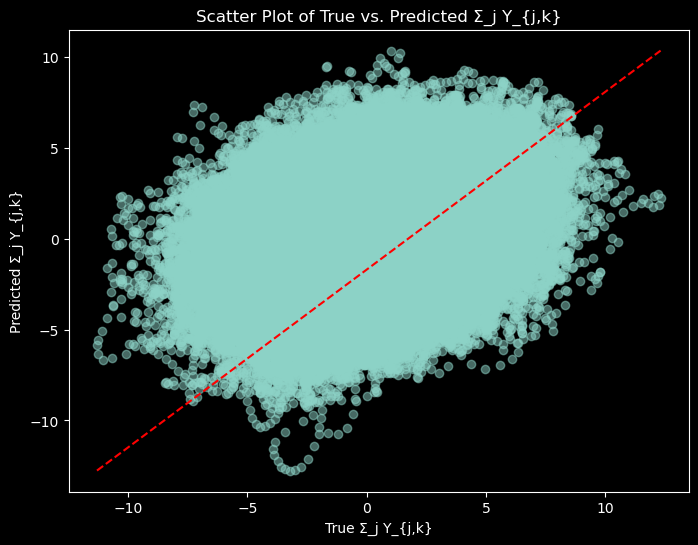

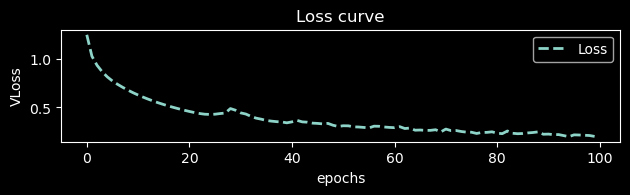

In [684]:
M1.eval()  # Set model to evaluation mode (disables dropout, batch norm, etc.)
with torch.no_grad():
    # Predict Y values on the test set
    Y_pred_test = M1(X_test_tensor.float().to(device)).detach().cpu()
    
    # Compute the mean squared error on Y predictions
    test_loss = criterion(Y_pred_test, Y_test_tensor).item()
    print("\nTest Loss (MSE on Y):", test_loss)
    
    # Compute the sum of Y values for each test sample (summing over the 64 outputs)
    Y_pred_test_reshaped = Y_pred_test.view(-1, J, K)  # Reshape to (samples, J, K)
    Y_test_tensor_reshaped = Y_test_tensor.view(-1, J, K)  # Same for true values
    Y_pred_sum = Y_pred_test_reshaped.sum(dim=1)
    Y_test_sum = Y_test_tensor_reshaped.sum(dim=1)
    
    # Compute the MSE loss for the summed Y values
    sum_loss = criterion(Y_pred_sum, Y_test_sum).item()
    print("Test Loss (MSE on summed Y):", sum_loss)


# Plot an example of predicted Y vs true Y for one test sample
plt.figure(figsize=(6, 6))
plt.subplot(3, 1, 1)
plt.plot(Y_test_tensor[0].numpy(), label="True Y")
plt.plot(Y_pred_test[0].numpy(), label="Predicted Y", linestyle='dashed')
plt.title("Example Y Prediction")
plt.xlabel("Y index")
plt.ylabel("Normalized value")
plt.legend()

compute_SGS = lambda Y: np.sum(Y.reshape(8, 8), axis=1)

predicted_SGS = compute_SGS(Y_pred_test[1].numpy())
true_SGS = compute_SGS(Y_test_tensor[1].numpy())

plt.figure(figsize=(6, 6))
plt.subplot(3,1,2)
plt.plot(true_SGS, label='True SGS', linewidth=2)
plt.plot(predicted_SGS, '--', label='Predicted SGS', linewidth=2)
plt.title('Comparison of True and Predicted subgrid-scale forcing')
plt.xlabel('Dimension of Y')
plt.ylabel('Value')
plt.legend()
plt.show()


x_range = (Y_test_sum.cpu().numpy().flatten().min(),Y_test_sum.cpu().numpy().flatten().max())
y_range = (Y_pred_sum.cpu().numpy().flatten().min(), Y_pred_sum.cpu().numpy().flatten().max())
# Plot the true sum of Y values vs. the predicted sum for all test samples
plt.figure(figsize=(8, 6))
plt.scatter(Y_test_sum.cpu().numpy().flatten(), Y_pred_sum.cpu().numpy().flatten(), alpha=0.5)
plt.xlabel("True Σ_j Y_{j,k}")
plt.ylabel("Predicted Σ_j Y_{j,k}")
plt.title("Scatter Plot of True vs. Predicted Σ_j Y_{j,k}")
plt.plot(x_range, y_range, 'r--')  # Identity line
plt.show()

plt.subplot(3,1,3)
plt.plot(LOSS, '--', label='Loss', linewidth=2)
plt.title('Loss curve')
plt.xlabel('epochs')
plt.ylabel('VLoss')
plt.legend()

plt.tight_layout()
plt.show()

## Part C
(c) For (a), couple the model, M1 to Eq (1) and simulate the system (Go
back to the video where I explain the hybrid physics engine + AI engine). This
is tricky. You need to write the numerical solver in such a way that the Σj Yj,k
term is now obtained from M1. Can you stabilize this system?

In [685]:
# Define simulation parameters
K = 8       # X (K=8)
J = 8       # Y (K*J=64)
I = 8       # Z (K*J*I=512)

F = 20      # Forcing parameter (high chaos)
h = 0.5     # Coupling parameter (medium coupling)
c = 8    # Time Scale parameter (small scale Y evolves faster than X)
# b = 1.0     # Parameter b (assumed to be 1 here)

dt = 0.0025  # Time step for integration
max_t = 750 # Total simulation time
num_steps = int(max_t / dt)  # Number of integration steps

In [686]:
# numerical solver for dX/dt of the lorentz system
# using the predicted Σj Yj,k from M1

# dXk/dt = Xk−1 (Xk+1 − Xk−2) − Xk + F − hcb Σj Yj,k 
def step_x(X, y_k):
    b = 10
    minus = [-1, 0, 1, 2, 3, 4, 5, 6]
    minus2 = [-2, -1, 0, 1, 2, 3, 4, 5]
    plus = [1, 2, 3, 4, 5, 6, 7, 0]
    x_minus = X[minus]
    x_plus = X[plus]
    x_minus2 = X[minus2]
    
    # print(f"X.shape: {X.shape}")
    # print(f"y_k.shape: {y_k.shape}")
    # print(f"x_minus.shape: {x_minus.shape}")
    # print(f"x_plus.shape: {x_plus.shape}")
    # print(f"x_minus2.shape: {x_minus2.shape}")
    
    dx = x_minus * (x_plus - x_minus2) - X + F - (h * c / b) * y_k
    return dx



Model M1 used for prediction:
Net(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=64, bias=True)
)
Simulation complete.
Shape of X: (300000, 8)


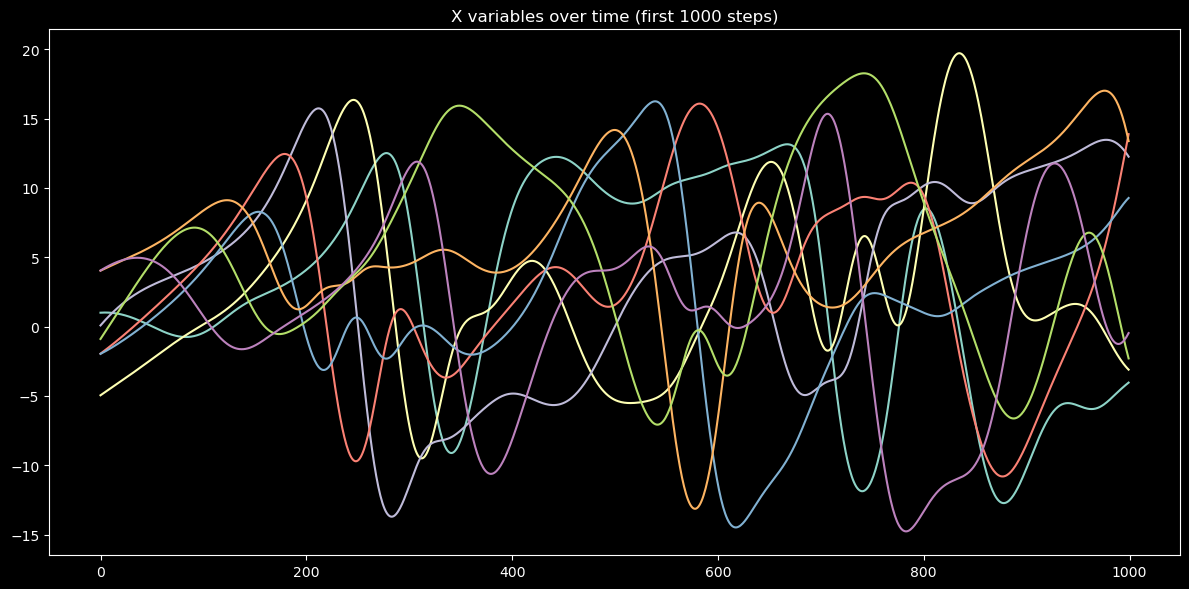

In [687]:
X = np.random.randint(-5, 5, K).astype(float)

print("Model M1 used for prediction:")
print(M1)

# Normalize the data (zero mean, unit variance) for X and Y separately
X_mean = np.mean(X)
X_std = np.std(X)
x_store_norm = (X - X_mean) / X_std
X_tensor = torch.tensor(X, dtype=torch.float32)

X_sol = np.zeros((num_steps, K))

y_pred = M1(X_tensor.float().to(device)).detach().cpu()
y_reshape = y_pred.view(-1, J, K)
y_k = y_reshape.sum(dim=1)
y_k = y_k[0].numpy()

for i in range(num_steps):
    dx = step_x(X_tensor, y_k)
    X_tensor = X_tensor + dt * dx
    
    X_sol[i, :] = X_tensor.cpu().numpy()
    
print("Simulation complete.")
print("Shape of X:", X_sol.shape)

# Optional: Plot a small segment of the simulation for visualization
plt.figure(figsize=(12, 6))
plt.plot(X_sol[:1000])
plt.title("X variables over time (first 1000 steps)")

plt.tight_layout()
plt.show()

Simulation complete.
Shape of X: (300000, 8)
Shape of Y: (300000, 64)


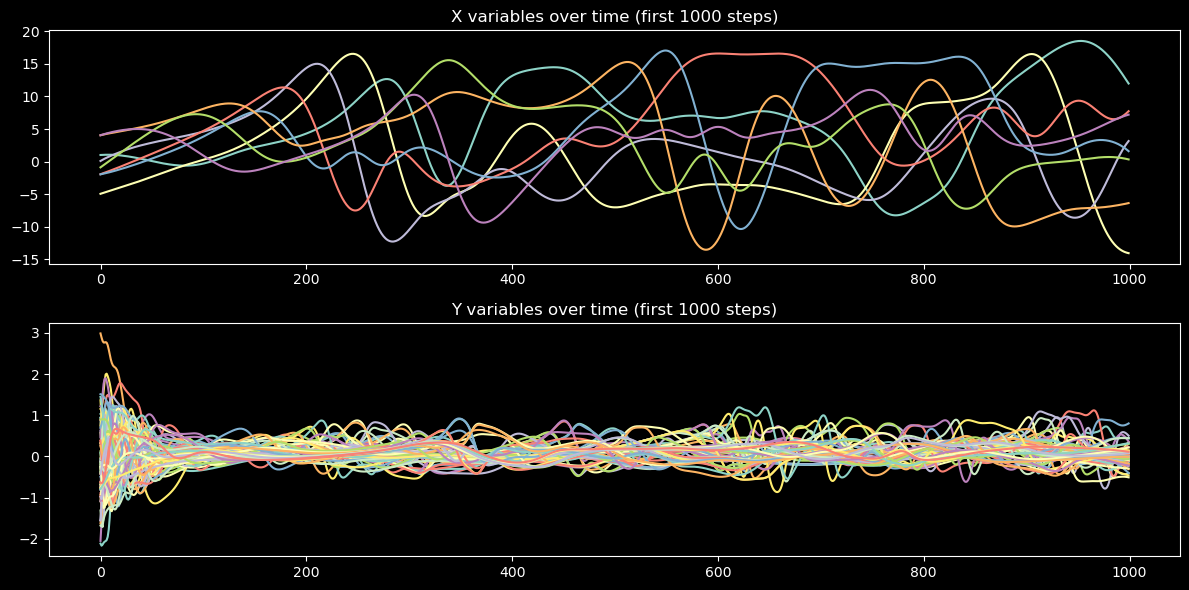

In [688]:
# Generate exact data to compare with the prediction
Y = np.random.randn(J, K)
# Z is unused but defined as a JXKXI tensor
Z = 0.05*np.random.randn(J,K,I)

Y_sol = np.zeros((num_steps, int(K*J)))
true_x = np.zeros((num_steps, K))

for i in range(num_steps):

    [dx1, dy1, dz1] = step(X,Y,Z)

    Rx2=X+.5*dt*dx1
    Ry2=Y+.5*dt*dy1
    Rz2=Z+.5*dt*dz1

    [dx2, dy2, dz2] = step(Rx2,Ry2,Rz2)

    Rx3=X+.5*dt*dx2
    Ry3=Y+.5*dt*dy2
    Rz3=Z+.5*dt*dz2

    [dx3, dy3, dz3] = step(Rx3,Ry3,Rz3)

    Rx4=X+dt*dx3
    Ry4=Y+dt*dy3
    Rz4=Z+dt*dz3

    [dx4, dy4, dz4] = step(Rx4,Ry4,Rz4)
    X=X+dt/6*(dx1 + 2*dx2 + 2*dx3 + dx4)
    Y=Y+dt/6*(dy1 + 2*dy2 + 2*dy3 + dy4)
    Z=Z+dt/6*(dz1 + 2*dz2 + 2*dz3 + dz4)

    true_x[i,:]=X

    Y_sol[i,:]=Y.reshape((int(J*K),),order='F')
    
print("Simulation complete.")
print("Shape of X:", true_x.shape)
print("Shape of Y:", Y_sol.shape)

# Optional: Plot a small segment of the simulation for visualization
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(true_x[:1000])
plt.title("X variables over time (first 1000 steps)")
plt.subplot(2, 1, 2)
plt.plot(Y_sol[:1000])
plt.title("Y variables over time (first 1000 steps)")
plt.tight_layout()
plt.show()


X_sol shape: (300000, 8)
true_x shape: (300000, 8)
Test Loss (MSE on X): 112.33930969238281


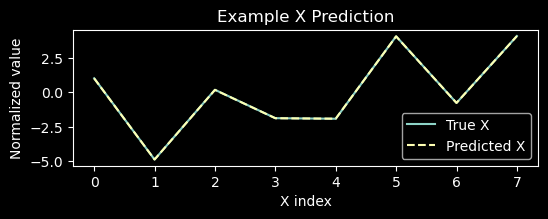

In [689]:
print("X_sol shape:", X_sol.shape)
print("true_x shape:", true_x.shape)
# Plot an example of predicted X vs true X for one test sample
plt.figure(figsize=(6, 6))
plt.subplot(3, 1, 1)
plt.plot(true_x[1], label="True X")
plt.plot(X_sol[1], label="Predicted X", linestyle='dashed')
plt.title("Example X Prediction")
plt.xlabel("X index")
plt.ylabel("Normalized value")
plt.legend()

sum_loss = criterion(torch.tensor(X_sol, dtype=torch.float32), torch.tensor(true_x, dtype=torch.float32)).item()
print("Test Loss (MSE on X):", sum_loss)

when dt is small, 0.0025 the system is stable. When dt is large, 0.005 the system is blows up